<a href="https://colab.research.google.com/github/kazuma0606/colabs/blob/master/monai_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install monai

In [ ]:
!pip install pytorch-ignite

In [ ]:
!pip install 'monai[all]'

In [ ]:
%matplotlib inline

import os
import sys
import tarfile
from urllib.request import urlopen
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Transform, Compose, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import Generator, Discriminator
from monai.networks import normal_init
from monai.utils import progress_bar

np.random.seed(0)

mednist_url = 'https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1'

disc_train_interval = 1
disc_train_steps = 5
batch_size = 300
latent_size = 64
num_epochs = 50
real_label = 1
gen_label = 0
learning_rate = 2e-4
betas = (0.5, 0.999)

device = torch.device('cuda:0')

In [ ]:
remote_file = urlopen(mednist_url)
dat=BytesIO(remote_file.read())

tar=tarfile.open('MedNIST.tar.gz', fileobj=dat)
hands = [n for n in tar.getnames() if 'Hand' in n and '.jpeg' in n]

In [ ]:
class LoadTarJpeg(Transform):
    def __call__(self, data):
        return plt.imread(tar.extractfile(data))
    

train_transforms = Compose([
    LoadTarJpeg(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor()
])

train_ds = monai.data.CacheDataset(hands, train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)

10000/10000 Load and cache transformed data:  [==============================]


In [ ]:
disc_net=Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2,  2,  2,  2, 1), 
    num_res_units=1,
    kernel_size=5
).to(device)


gen_net = Generator(
    latent_shape=latent_size,
    start_shape=(64, 8, 8),
    channels=[32, 16, 8, 1],
    strides=[2, 2, 2, 1]
)

# initialize both networks 
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# input images are scaled to [0,1] so enforce the same of generated outputs 
gen_net.conv.add_module('activation', torch.nn.Sigmoid()) 
gen_net = gen_net.to(device)

In [ ]:
disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()

disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)
 

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    realloss = disc_loss(disc_net(real_images), real)
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input)
    cats = output.new_full(output.shape, real_label)
    return gen_loss(output, cats)

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0

for epoch in range(num_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0
    
    for i, batch_data in enumerate(train_loader):
        progress_bar(i, len(train_loader), f"epoch {epoch + 1}, avg loss: {epoch_loss_values[-1][1]:.4f}")
        real_images = batch_data.to(device)
        latent = torch.randn(real_images.shape[0], latent_size).to(device)
        
        gen_opt.zero_grad()
        gen_images = gen_net(latent)
        loss = generator_loss(gen_images)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        gen_step_loss.append((step,loss.item()))
        
        if step % disc_train_interval == 0:
            disc_total_loss = 0
            
            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_images)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()
                
            disc_step_loss.append((step, disc_total_loss / disc_train_steps))
            
        step += 1
        
    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))
    
    clear_output(True)

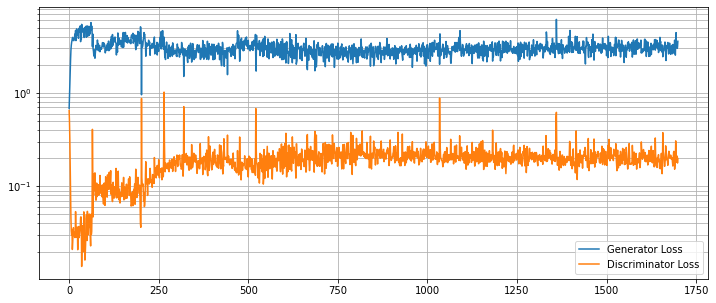

In [ ]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label='Generator Loss')
plt.semilogy(*zip(*disc_step_loss), label='Discriminator Loss')
plt.grid(True, 'both', 'both')
plt.legend()

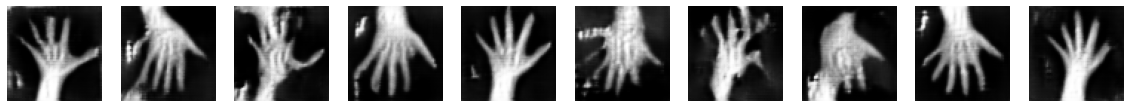

In [ ]:
test_size = 10
test_latent = torch.randn(test_size, latent_size).to(device)

test_images = gen_net(test_latent)

fig, axs = plt.subplots(1, test_size, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(test_images[i, 0].cpu().data.numpy(), cmap='gray')